In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import FDTDIResponseGenerator
from Triangle_BBH.Utils import Likelihood, Fstatistics
from Triangle_BBH.Fisher import *

# import multiprocessing
# if __name__=='__main__':
#     multiprocessing.set_start_method("fork")

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Data settings 

In [2]:
t_start = 200. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(21601,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*5e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_CPU = np.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((20732,), (20732,))

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_CPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") 

# initialize  waveform generator 
WFG_CPU = WaveformGenerator(
    mode="primary", 
    # mode="full", 
)

# initialize response generator 
FDTDI_CPU = FDTDIResponseGenerator(
    orbit_class=orbit_CPU, 
    waveform_generator=WFG_CPU, 
)

# response settings 
response_kwargs_CPU = dict(
    modes=[(2, 2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    tc_at_constellation=True, # whether tc is the coalescence time at constellation center (True) or SSB (False)
    TDIGeneration='2nd',
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
)

## Source parameter priors 

In [5]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [(t_start + 0.75 * Tobs) / DAY, (t_end - 0.1 * Tobs) / DAY] # ensure the inclusion of long enough GW waveform 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 2.03750000e+02,  2.04500000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

In [6]:
intrinsic_param_priors[4]

array([203.75, 204.5 ])

## Noise model 

In [7]:
arm_time = np.mean(intrinsic_param_priors[4]) * DAY 
print(arm_time/DAY)
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_CPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

204.125


((3, 20732), (20732, 3, 3))

## Data simulation 

In [8]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = np.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 530073.6043338986
mass_ratio : 0.8245299487159758
spin_1z : -0.2928571524429372
spin_2z : -0.530309637944049
coalescence_time : 203.88544531206443
coalescence_phase : 3.749274566690958
luminosity_distance : 17681.483556859745
inclination : 0.7480840416717085
longitude : 5.5673338319146755
latitude : 0.5086556358132113
psi : 0.6078705703804956
optimal SNR: 2101.724231585751


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

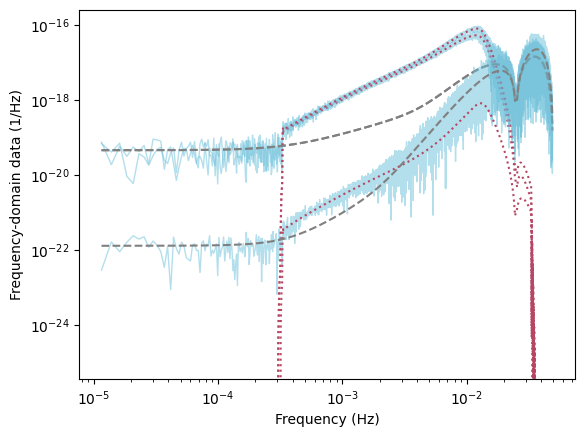

In [9]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel]), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel]), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [10]:
Fstat = Fstatistics(
    response_generator=FDTDI_CPU, 
    frequency=data_frequencies_CPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_CPU, 
    use_gpu=False
)

### test waveform and parameter recovery

In [11]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 530073.6043338986,
 'mass_ratio': 0.8245299487159758,
 'spin_1z': -0.2928571524429372,
 'spin_2z': -0.530309637944049,
 'coalescence_time': 203.88544531206443,
 'longitude': 5.5673338319146755,
 'latitude': 0.5086556358132113}

In [12]:
rec_a = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
# print(rec_a.shape)

rec_ext_params = Fstat.a_to_extrinsic(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | true value | difference")
for k, v in rec_ext_params.items():
    print(k, ":", mbhb_parameters[k], v-mbhb_parameters[k])

parameter name | true value | difference
luminosity_distance : 17681.483556859745 39.55357599434865
inclination : 0.7480840416717085 -0.003266078242746717
psi : 0.6078705703804956 0.010891568505810079
coalescence_phase : 3.749274566690958 -3.1311543625674885


In [13]:
rec_wave1 = FDTDI_CPU.Response(
    rec_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

rec_wave2 = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)

rec_wave1.shape, rec_wave2.shape 

((3, 20732), (3, 20732))

(1e-25, 7.847786793813788e-16)

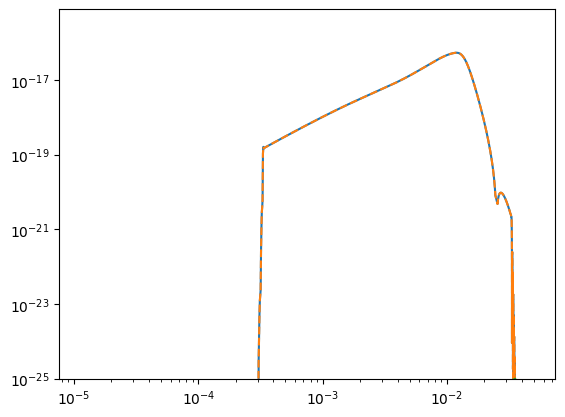

In [14]:
plt.loglog(data_frequencies_CPU, np.abs(rec_wave1[0]))
plt.loglog(data_frequencies_CPU, np.abs(rec_wave2[0]), linestyle="--")
plt.loglog(data_frequencies_CPU, np.abs(rec_wave1[0] - rec_wave2[0]))
plt.ylim(1e-25,)

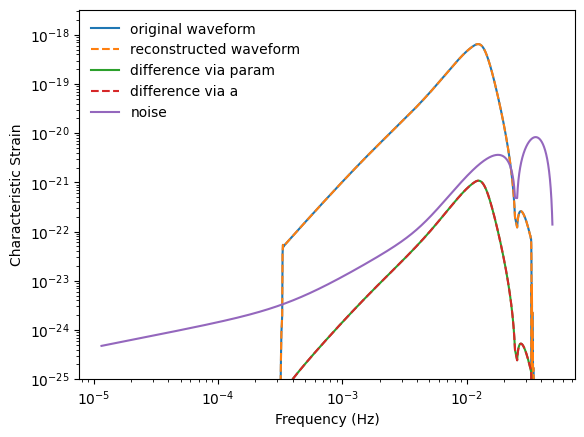

In [15]:
plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0]) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0] - wf_channels[0]) * data_frequencies, label="difference via param")
plt.loglog(data_frequencies, np.abs(rec_wave2[0] - wf_channels[0]) * data_frequencies, label="difference via a", linestyle="--")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

### optimization from prior 

In [16]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams), normalized to (0, 1)
    """
    int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
    return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-8,
    atol=1e-10,
    # tol=1e-6,
    # atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=True,
    # vectorized=True,
    workers=30, 
)

/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))


In [17]:
print(DE_result)

             message: Optimization terminated successfully.
             success: True
                 fun: -2209060.8172970843
                   x: [ 2.243e-01  7.808e-01  3.914e-01  1.352e-01
                        1.806e-01  8.850e-01  7.479e-01]
                 nit: 279
                nfev: 137232
          population: [[ 2.243e-01  7.808e-01 ...  8.850e-01  7.479e-01]
                       [ 2.243e-01  7.823e-01 ...  8.851e-01  7.470e-01]
                       ...
                       [ 2.243e-01  7.803e-01 ...  8.849e-01  7.478e-01]
                       [ 2.243e-01  7.796e-01 ...  8.849e-01  7.478e-01]]
 population_energies: [-2.209e+06 -2.209e+06 ... -2.209e+06 -2.209e+06]
                 jac: [-6.871e+02 -3.893e+01  1.710e+02  1.083e+02
                        1.025e+04 -2.668e+01 -1.378e+01]


### reconstruct parameters and waveforms 

In [18]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

print("parameter name | true value | difference")
for k, v in searched_params.items():
    print(k, mbhb_parameters[k], np.abs(v-mbhb_parameters[k]))

parameter name | true value | difference
chirp_mass 530073.6043338986 15.62247353233397
mass_ratio 0.8245299487159758 0.021797608454195205
spin_1z -0.2928571524429372 0.09745318883214948
spin_2z -0.530309637944049 0.12638971413099842
coalescence_time 203.88544531206443 1.414274208855204e-06
longitude 5.5673338319146755 0.006622776607757785
latitude 0.5086556358132113 0.010020368032813254
luminosity_distance 17681.483556859745 70.318689336018
inclination 0.7480840416717085 0.015986097686227163
psi 0.6078705703804956 0.14394985499979607
coalescence_phase 3.749274566690958 3.0073536913542656


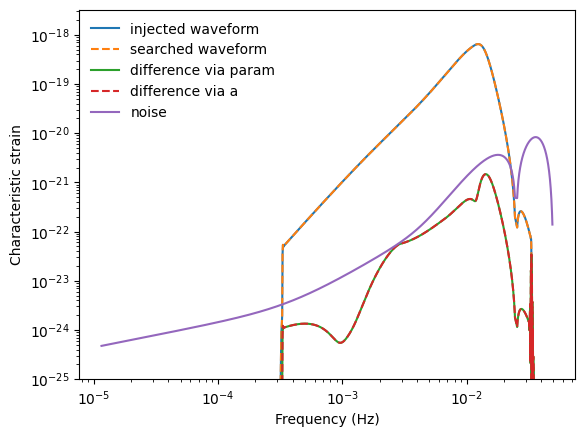

In [19]:
searched_wf1 = FDTDI_CPU.Response(
    searched_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

searched_wf2 = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)

plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0]) * data_frequencies, linestyle="--", label="searched waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0] - wf_channels[0]) * data_frequencies, linestyle="-", label="difference via param")
plt.loglog(data_frequencies, np.abs(searched_wf2[0] - wf_channels[0]) * data_frequencies, linestyle="--", label="difference via a")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.legend(loc="upper left", frameon=False)

## Fisher analysis 

In [20]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_CPU.Response(
        parameters=param_dict, 
        freqs=np.array(frequencies),  
        **response_kwargs_CPU, 
    )
    return res

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    param_dict=mbhb_parameters, 
    # param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 37.232286974414514,
 'mass_ratio': 0.010669783053684958,
 'spin_1z': 0.05046539329192628,
 'spin_2z': 0.06388975371794585,
 'coalescence_time': 1.074585854496555e-06,
 'coalescence_phase': 0.10288273990738324,
 'luminosity_distance': 766.5201530019616,
 'inclination': 0.07549262181643394,
 'longitude': 0.012846222772518052,
 'latitude': 0.00892592788552055,
 'psi': 0.10656700348830687}

In [21]:
print("parameter name | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

parameter name | difference | FIM bound | ratio
chirp_mass 15.62247353233397 37.232286974414514 0.4195947872627192
mass_ratio 0.021797608454195205 0.010669783053684958 2.0429289278442355
spin_1z 0.09745318883214948 0.05046539329192628 1.931089455072979
spin_2z 0.12638971413099842 0.06388975371794585 1.9782470079470207
coalescence_time 1.414274208855204e-06 1.074585854496555e-06 1.3161109491040095
longitude 0.006622776607757785 0.012846222772518052 0.5155427182787071
latitude 0.010020368032813254 0.00892592788552055 1.1226135995416322
luminosity_distance 70.318689336018 766.5201530019616 0.0917375610551469
inclination 0.015986097686227163 0.07549262181643394 0.2117570870051192
psi 0.14394985499979607 0.10656700348830687 1.3507919927164982
coalescence_phase 3.0073536913542656 0.10288273990738324 29.23088648359808


## Test across population 

In [22]:
truths_list = [] 
searched_list = [] 
FIM_bound_list = [] 
snr_list = [] 
res_snr_list = [] 

for test_idx in tqdm(range(100)):

    # generate source parameter and clean signal 
    # mbhb_parameters = {
    #     'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    #     'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    #     'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    #     'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    #     'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    #     'coalescence_phase': np.random.uniform(0, TWOPI),
    #     'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    #     'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    #     'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    #     'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    #     'psi': np.random.uniform(0, PI) # [rad]
    #     }
    wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

    # generate frequency-domain noises 
    Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    noise_channels = np.array(Re_tmp + 1.j * Im_tmp) 

    # combine signal and noise 
    data_channels = wf_channels + noise_channels 

    opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)
    snr_list.append(opt_SNR)

    Fstat = Fstatistics(
        response_generator=FDTDI_CPU, 
        frequency=data_frequencies_CPU, 
        data=data_channels, 
        invserse_covariance_matrix=InvCovMat, 
        response_parameters=response_kwargs_CPU, 
        use_gpu=False
    )

    def cost_function(norm_int_params):
        """   
            norm_int_params: shape (Nparams), normalized to (0, 1)
        """
        int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
        params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
        return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

    n_dim_int = 7 
    lower_bounds = np.zeros(n_dim_int) 
    upper_bounds = np.ones(n_dim_int) 
    bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

    DE_result = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-8,
        atol=1e-10,
        # tol=1e-7,
        # atol=1e-9,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=True,
        # vectorized=True,
        workers=30, 
    )

    searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

    searched_a = Fstat.calculate_Fstat(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic(searched_a)

    searched_params = dict(searched_int_params, **searched_ext_params)
    
    searched_wf = Fstat.calculate_Fstat(
        intrinsic_parameters=searched_int_params, 
        return_recovered_wave=True, 
    ) 
    res_snr_list.append(FrequencyDomainCovarianceSNR(searched_wf-wf_channels, InvCovMat))

    
    def fisher_waveform_wrapper(param_dict, frequencies):
        res = FDTDI_CPU.Response(
            parameters=param_dict, 
            freqs=np.array(frequencies),  
            **response_kwargs_CPU, 
        )
        return res

    # set initial steps 
    analyze_param_step_dict = {
        'chirp_mass': 10.,
        'mass_ratio': 0.01,
        'spin_1z': 0.01,
        'spin_2z': 0.01,
        'coalescence_time': 0.001,
        'coalescence_phase': 0.01,
        'luminosity_distance': 10.,
        'inclination': 0.01,
        'longitude': 0.01,
        'latitude': 0.01,
        'psi': 0.01
        }
    for k, v in analyze_param_step_dict.items():
        analyze_param_step_dict[k] = -v 

    FIM = MultiChannelFisher(
        waveform_generator=fisher_waveform_wrapper, 
        param_dict=mbhb_parameters, 
        # param_dict=searched_params, 
        analyze_param_step_dict=analyze_param_step_dict, 
        frequency=data_frequencies, 
        inverse_covariance=InvCovMat, 
        verbose=0,
    )

    FIM.auto_test_step()
    FIM.calculate_Fisher()
    FIM.calculate_errors() 

    truths_list.append(mbhb_parameters)
    searched_list.append(searched_params)
    FIM_bound_list.append(FIM.param_errors)
    
    print("optimal SNR =", snr_list[test_idx])
    print("residual SNR =", res_snr_list[test_idx])
    print("tc deviation =", truths_list[test_idx]["coalescence_time"] - searched_list[test_idx]["coalescence_time"])
    print("tc bound =", FIM_bound_list[test_idx]["coalescence_time"])
    print("longitude deviation=", searched_list[test_idx]["longitude"] - truths_list[test_idx]["longitude"])
    print("latitude deviation=", searched_list[test_idx]["latitude"] - truths_list[test_idx]["latitude"])
    

  0%|          | 0/100 [00:00<?, ?it/s]/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages

optimal SNR = 2101.724231585751
residual SNR = 4.963677935060095
tc deviation = 3.341341994200775e-07
tc bound = 1.074585854496555e-06
longitude deviation= -5.513559654193957
latitude deviation= 0.4988618364628188


  2%|▏         | 2/100 [37:23<30:43:52, 1128.90s/it]

optimal SNR = 2101.724231585751
residual SNR = 5.073615064500324
tc deviation = -1.2049398492308683e-06
tc bound = 1.074585854496555e-06
longitude deviation= -5.503939644430938
latitude deviation= 0.5223743204814493


/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
  3%|▎         | 3/100 [56:19<30:30:24, 1132.22s/it]

optimal SNR = 2101.724231585751
residual SNR = 3.778761915253777
tc deviation = 6.048009311143687e-07
tc bound = 1.074585854496555e-06
longitude deviation= 0.014733763184756832
latitude deviation= -0.00039781479852474266


/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/home/ps/miniconda3/envs/glow_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:1

optimal SNR = 2101.724231585751
residual SNR = 3.4800382101631504
tc deviation = -2.2071898797548783e-07
tc bound = 1.074585854496555e-06
longitude deviation= -0.015374169956785089
latitude deviation= -0.010483250241482722


Process ForkPoolWorker-156:
Process ForkPoolWorker-158:
Process ForkPoolWorker-167:
Process ForkPoolWorker-173:
Process ForkPoolWorker-159:
Process ForkPoolWorker-177:
Process ForkPoolWorker-151:
Process ForkPoolWorker-153:
Process ForkPoolWorker-164:
Process ForkPoolWorker-180:
Process ForkPoolWorker-161:
Process ForkPoolWorker-165:
Process ForkPoolWorker-178:
Process ForkPoolWorker-179:
Process ForkPoolWorker-152:
Process ForkPoolWorker-166:
Process ForkPoolWorker-174:
Process ForkPoolWorker-175:
Process ForkPoolWorker-168:
Process ForkPoolWorker-172:
Process ForkPoolWorker-169:
Process ForkPoolWorker-154:
Process ForkPoolWorker-162:
Process ForkPoolWorker-157:
Process ForkPoolWorker-163:
Process ForkPoolWorker-170:
  4%|▍         | 4/100 [1:15:21<30:08:46, 1130.48s/it]


KeyboardInterrupt: 

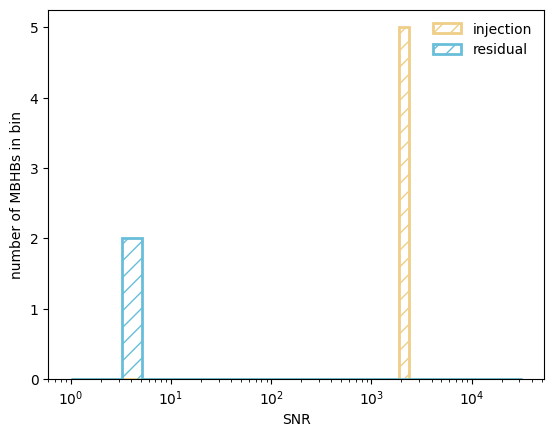

In [23]:
bins = np.logspace(0, 4.5, 45)
plt.hist(snr_list, bins=bins, density=False, facecolor=None, edgecolor=YELLOW, hatch="//", histtype='step', lw=2, label="injection"); 
plt.hist(res_snr_list, bins=bins, density=False, facecolor=None, edgecolor=BLUE, hatch="//", histtype='step', lw=2, label="residual"); 
plt.xlabel("SNR")
plt.ylabel("number of MBHBs in bin")
plt.xscale("log")
plt.legend(loc="upper right", frameon=False)

In [24]:
Mc_list = np.array([paramdict["chirp_mass"] for paramdict in truths_list])
q_list = np.array([paramdict["mass_ratio"] for paramdict in truths_list])
s1_list = np.array([paramdict["spin_1z"] for paramdict in truths_list])
s2_list = np.array([paramdict["spin_2z"] for paramdict in truths_list])
tc_list = np.array([paramdict["coalescence_time"] for paramdict in truths_list])
dl_list = np.array([paramdict["luminosity_distance"] for paramdict in truths_list])
inc_list = np.array([paramdict["inclination"] for paramdict in truths_list])
lon_list = np.array([paramdict["longitude"] for paramdict in truths_list])
lat_list = np.array([paramdict["latitude"] for paramdict in truths_list])

Mc_list1 = np.array([paramdict["chirp_mass"] for paramdict in searched_list])
q_list1 = np.array([paramdict["mass_ratio"] for paramdict in searched_list])
s1_list1 = np.array([paramdict["spin_1z"] for paramdict in searched_list])
s2_list1 = np.array([paramdict["spin_2z"] for paramdict in searched_list])
tc_list1 = np.array([paramdict["coalescence_time"] for paramdict in searched_list])
dl_list1 = np.array([paramdict["luminosity_distance"] for paramdict in searched_list])
inc_list1 = np.array([paramdict["inclination"] for paramdict in searched_list])
lon_list1 = np.array([paramdict["longitude"] for paramdict in searched_list])
lat_list1 = np.array([paramdict["latitude"] for paramdict in searched_list])

Mc_list2 = np.array([paramdict["chirp_mass"] for paramdict in FIM_bound_list])
q_list2 = np.array([paramdict["mass_ratio"] for paramdict in FIM_bound_list])
s1_list2 = np.array([paramdict["spin_1z"] for paramdict in FIM_bound_list])
s2_list2 = np.array([paramdict["spin_2z"] for paramdict in FIM_bound_list])
tc_list2 = np.array([paramdict["coalescence_time"] for paramdict in FIM_bound_list])
dl_list2 = np.array([paramdict["luminosity_distance"] for paramdict in FIM_bound_list])
inc_list2 = np.array([paramdict["inclination"] for paramdict in FIM_bound_list])
lon_list2 = np.array([paramdict["longitude"] for paramdict in FIM_bound_list])
lat_list2 = np.array([paramdict["latitude"] for paramdict in FIM_bound_list])

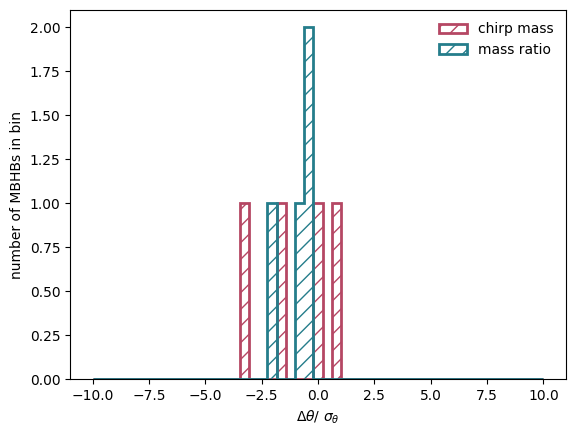

In [25]:
bins = np.linspace(-10, 10, 50)
plt.hist((Mc_list1 - Mc_list) / Mc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="chirp mass");
plt.hist((q_list1 - q_list) / q_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="mass ratio");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

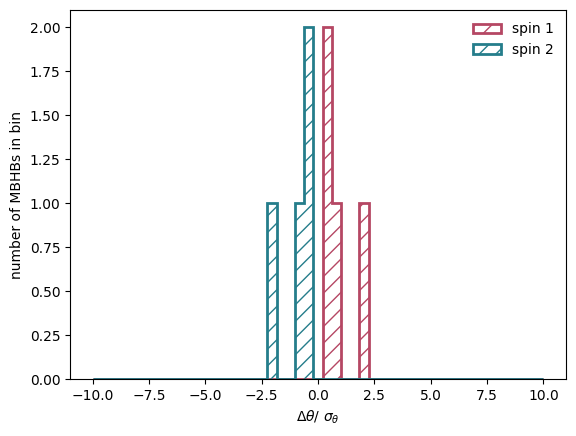

In [26]:
bins = np.linspace(-10, 10, 50)
plt.hist((s1_list1 - s1_list) / s1_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="spin 1");
plt.hist((s2_list1 - s2_list) / s2_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="spin 2");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

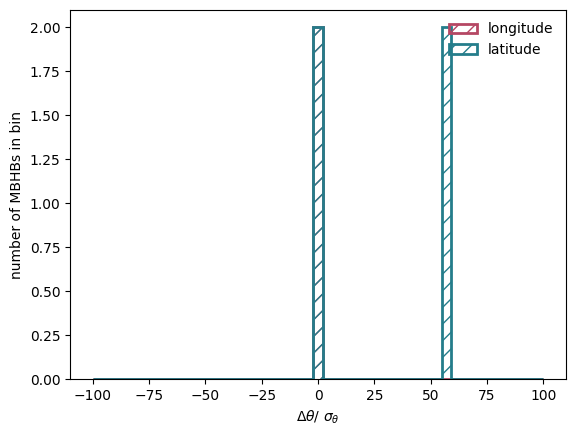

In [27]:
bins = np.linspace(-100, 100, 50)
plt.hist((lon_list1 - lon_list) / lon_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="longitude");
plt.hist((lat_list1 - lat_list) / lat_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="latitude");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

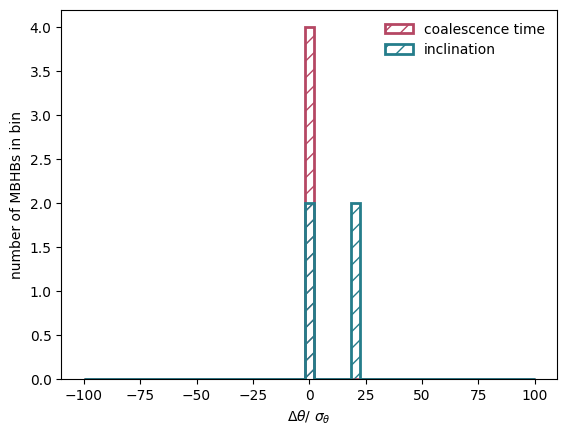

In [28]:
bins = np.linspace(-100, 100, 50)
plt.hist((tc_list1 - tc_list) / tc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="coalescence time");
plt.hist((inc_list1 - inc_list) / inc_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="inclination");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

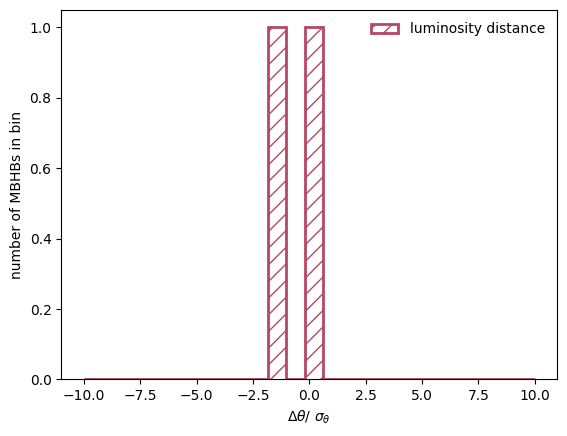

In [29]:
bins = np.linspace(-10, 10, 50)
plt.hist((dl_list1 - dl_list) / dl_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="luminosity distance");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [32]:
lon_list, lon_list1, lon_list2

(array([5.56733383, 5.56733383, 5.56733383, 5.56733383]),
 array([0.05377418, 0.06339419, 5.5820676 , 5.55195966]),
 array([0.01284622, 0.01284622, 0.01284622, 0.01284622]))

In [33]:
lat_list, lat_list1, lat_list2

(array([0.50865564, 0.50865564, 0.50865564, 0.50865564]),
 array([1.00751747, 1.03102996, 0.50825782, 0.49817239]),
 array([0.00892593, 0.00892593, 0.00892593, 0.00892593]))

In [34]:
inc_list, inc_list1, inc_list2

(array([0.74808404, 0.74808404, 0.74808404, 0.74808404]),
 array([2.42036082, 2.29071645, 0.72023419, 0.83803669]),
 array([0.07549262, 0.07549262, 0.07549262, 0.07549262]))